In [510]:
#from lucas.stay_overnight import new_succesful_project
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import pandas as pd

#Load the data
df = pd.read_csv(r"C:\Users\USER\Desktop\Uni lvl 100\AI DataSet\boxoffice.csv")

In [404]:
# Apply log transformation to stabilize revenue scale
df['world_revenue'] = np.log1p(df['world_revenue'])

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['MPAA'] = label_encoder.fit_transform(df['MPAA'])

In [406]:
#df = pd.get_dummies(df, columns=['distributor', 'genres'], drop_first=True)

In [408]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             2694 non-null   object 
 1   domestic_revenue  2694 non-null   int64  
 2   world_revenue     2694 non-null   float64
 3   distributor       2694 non-null   object 
 4   opening_revenue   2694 non-null   int64  
 5   opening_theaters  2694 non-null   int64  
 6   budget            2694 non-null   int64  
 7   MPAA              2694 non-null   int32  
 8   genres            2694 non-null   object 
 9   release_days      2694 non-null   int64  
dtypes: float64(1), int32(1), int64(5), object(3)
memory usage: 200.1+ KB


In [438]:
# Features and target variable
# Select features (include one-hot encoded distributor & genre columns)
X = df[['opening_revenue', 'opening_theaters', 'release_days', 'MPAA', 'world_revenue']] #+
       #[col for col in df.columns if col.startswith('distributor_') or col.startswith('genres_')]]

# Target variable
y = df['world_revenue']

# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Corrected from fit_transform to transform

In [440]:
# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_scaled, y_train)

# Predict the target variable
y_pred = rf_regressor.predict(X_test_scaled)

# Evaluate regression model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R-Squared:", r2_score(y_test, y_pred))

Mean Squared Error: 7.52828461133478e-05
Mean Absolute Error: 0.0018517589575380684
R-Squared: 0.9999189924424298


In [442]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(rf_regressor, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)  # Fit on scaled data

# Print best parameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [443]:
# Retrain the model with the best hyperparameters
best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_rf.fit(X_train_scaled, y_train)

# Predict & Evaluate the optimized model
y_pred = best_rf.predict(X_test_scaled)

print("Optimized Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Optimized Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Optimized R-Squared:", r2_score(y_test, y_pred))

Optimized Mean Squared Error: 6.946823383578336e-05
Optimized Mean Absolute Error: 0.001859458167466593
Optimized R-Squared: 0.9999252492135688


USING XGBOOST

In [448]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Feature Selection
X = df[['opening_revenue', 'opening_theaters', 'release_days', 'MPAA', 'world_revenue']]
y = df['world_revenue']

# Apply log transformation to stabilize revenue range
y = np.log1p(y)  

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost model
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
model_xgb.fit(X_train_scaled, y_train)

# Predict
y_pred = model_xgb.predict(X_test_scaled)

# Evaluate model
print("📊 Model Evaluation Metrics 📊")
print("🔹 MSE:", mean_squared_error(y_test, y_pred))
print("🔹 MAE:", mean_absolute_error(y_test, y_pred))
print("🔹 R-Squared:", r2_score(y_test, y_pred))


📊 Model Evaluation Metrics 📊
🔹 MSE: 5.6207750220879956e-06
🔹 MAE: 0.000477159887502661
🔹 R-Squared: 0.9975362296734366


In [451]:
model_xgb.feature_importances_

array([8.1425707e-04, 3.4741801e-04, 3.8144959e-04, 3.2358928e-04,
       9.9813330e-01], dtype=float32)

__________________________________
CHECKING MOST IMPACTFUL FEATURE
__________________________________

In [453]:
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': model_xgb.feature_importances_})
print(importance_df.sort_values(by='Importance', ascending=False))

            Feature  Importance
4     world_revenue    0.998133
0   opening_revenue    0.000814
2      release_days    0.000381
1  opening_theaters    0.000347
3              MPAA    0.000324


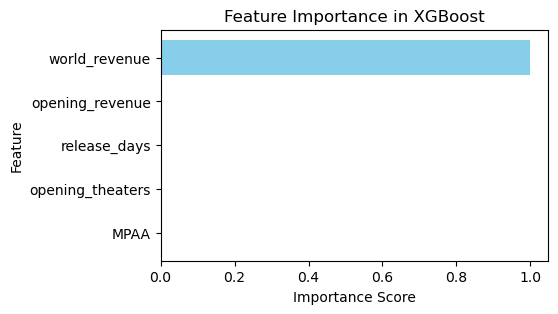

In [463]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(5, 3))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in XGBoost")
plt.gca().invert_yaxis()  # Invert y-axis for better visibility
plt.show()


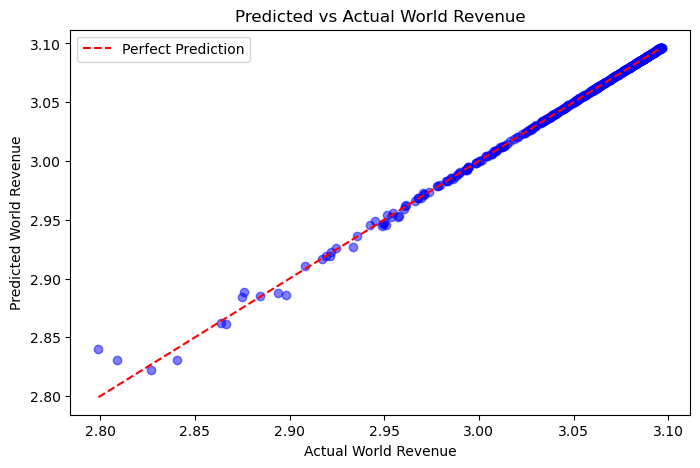

In [470]:
#Visualization 1: Predictions vs Actual Revenue
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='Perfect Prediction')
plt.xlabel("Actual World Revenue")
plt.ylabel("Predicted World Revenue")
plt.title("Predicted vs Actual World Revenue")
plt.legend()
plt.show()

#✔ If points align with the red line, predictions are very close to actual values.


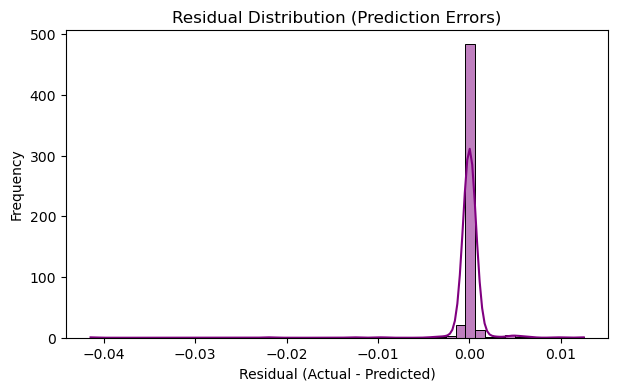

In [474]:
#Visualization 2: Residual Plot
import seaborn as sns

# Compute residuals
residuals = y_test - y_pred

# Create residual plot
plt.figure(figsize=(7, 4))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution (Prediction Errors)")
plt.show()

#✔ A normal-shaped distribution means errors are evenly spread, indicating a good model.

In [504]:
import pandas as pd

# Create DataFrame with Release Days, MPAA Rating, Actual Revenue, and Predicted Revenue
results_df = pd.DataFrame({
    'Release Days': X_test['release_days'].values,  # Retrieve associated release days
    'MPAA Rating': X_test['MPAA'].values,  # Retrieve MPAA ratings
    'Actual Revenue': y_test.values,
    'Predicted Revenue': y_pred
})

# Display first few rows
print(results_df.head(10))

# Save the results to a CSV file for further analysis
results_df.to_csv("predictions_vs_actual_with_release_days_MPAA.csv", index=False)

# MPAA Rating Encoding:
# 0 = G (General Audience)
# 1 = PG (Parental Guidance Suggested)
# 2 = PG-13 (Parents Strongly Cautioned)
# 3 = R (Restricted)
# 4 = NC-17 (Adults Only)



   Release Days  MPAA Rating  Actual Revenue  Predicted Revenue
0           130            2        3.054253           3.054179
1           126            2        3.096133           3.096016
2            84            4        3.058974           3.059028
3            50            4        3.096653           3.096548
4            10            4        3.091380           3.091437
5            56            3        3.073542           3.073503
6            30            3        3.047813           3.047807
7            49            1        3.079374           3.079522
8            15            3        3.089053           3.088999
9            54            2        3.066054           3.066047


In [506]:
results_df.to_csv("predictions_vs_actual.csv", index=False)